In [1]:
import os

import gym
import numpy as np
from hydra.core.config_store import ConfigStore

import habitat
import habitat.gym
from habitat.core.embodied_task import Measure
from habitat.core.registry import registry
from habitat.tasks.rearrange.rearrange_sensors import RearrangeReward
from habitat.tasks.rearrange.rearrange_task import RearrangeTask
from habitat.utils.visualizations.utils import (
    observations_to_image,
    overlay_frame,
)
from habitat_baselines.common.env_spec import EnvironmentSpec

from habitat_baselines.rl.ddppo.ddp_utils import (
    EXIT,
    get_distrib_size,
    init_distrib_slurm,
    is_slurm_batch_job,
    load_resume_state,
    rank0_only,
    requeue_job,
    save_resume_state,
)
import hydra
from habitat_baselines.common.baseline_registry import baseline_registry

from habitat_sim.utils import viz_utils as vut
import torch

from habitat_baselines.common.obs_transformers import (
    apply_obs_transforms_batch,
    apply_obs_transforms_obs_space,
    get_active_obs_transforms,
)
from habitat_baselines.utils.common import (
    batch_obs,
    generate_video,
    get_action_space_info,
    inference_mode,
    is_continuous_action_space,
)

from lmnav.emb_transfer.old_eai_policy import OldEAIPolicy


# Quiet the Habitat simulator logging
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"

os.chdir('/srv/flash1/pputta7/projects/lm-nav')

In [11]:
config = habitat.get_config("config/imagenav_hm3d.yaml")
env = habitat.Env(config=config)
obs_transforms = [baseline_registry.get_obs_transformer('ResizeShortestEdge')(size=120, trans_keys=('rgb', 'depth', 'imagegoal'))]
obs_space = apply_obs_transforms_obs_space(env.observation_space, obs_transforms)

2023-08-31 11:11:23,510 Initializing dataset PointNav-v1
2023-08-31 11:11:23,920 initializing sim Sim-v0
2023-08-31 11:11:24,930 Initializing task Nav-v0
2023-08-31 11:11:24,953 Resizing observation of depth: from (480, 640) to (120, 160)
2023-08-31 11:11:24,955 Resizing observation of imagegoal: from (480, 640) to (120, 160)
2023-08-31 11:11:24,956 Resizing observation of rgb: from (480, 640) to (120, 160)


In [5]:
teacher = OldEAIPolicy.hardcoded(OldEAIPolicy, obs_space, env.action_space)
device = 'cuda'
torch.set_grad_enabled(False)

teacher_ckpt = "models/uLHP.300.pth"
ckpt_dict = torch.load(teacher_ckpt)
state_dict = ckpt_dict['state_dict']
state_dict = {k[len('actor_critic.'):]: v for k, v in state_dict.items()}

teacher.load_state_dict(state_dict)
teacher.to('cuda')

2023-08-31 11:09:00,346 Using weights from /srv/flash1/rramrakhya6/summer_2022/mae-for-eai/data/visual_encoders/mae_vit_small_decoder_large_HGPS_RE10K_100.pth: _IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token', 'decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weigh

OldEAIPolicy(
  (net): EAINet(
    (rgb_scaler): Resize(size=(120, 160), interpolation=bilinear, max_size=None, antialias=warn)
    (visual_encoder): VisualEncoder(
      (running_mean_and_var): RunningMeanAndVar()
      (backbone): VisionTransformer(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
          (norm): Identity()
        )
        (pos_drop): Dropout(p=0.0, inplace=False)
        (patch_drop): Identity()
        (norm_pre): Identity()
        (blocks): Sequential(
          (0): Block(
            (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): Linear(in_features=384, out_features=1152, bias=True)
              (q_norm): Identity()
              (k_norm): Identity()
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=384, out_features=384, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=Fal

In [6]:
def batch_to(device):
    batch['rgb'] = batch['rgb'].to(device)
    batch['depth'] = batch['depth'].to(device)
    batch['imagegoal'] = batch['imagegoal'].to(device)
    
test_recurrent_hidden_states = torch.zeros((1, 2, 512), device=device)
prev_actions = torch.zeros(1, 1, device=device, dtype=torch.long)
not_done_masks = torch.ones(1, 1, device=device, dtype=torch.bool)
rgb_frames = []

In [8]:
observations = env.reset()

In [3]:
step = 0
done = False

while step < 500 and not done:
    # batch data up
    batch = batch_obs([observations])
    batch = apply_obs_transforms_batch(batch, obs_transforms)
    batch_to('cuda')
    
    rgb_frames.append(observations['rgb'].copy())
    
    # query policy for next action
    policy_result = teacher.act(batch, test_recurrent_hidden_states, prev_actions, not_done_masks, deterministic=False)
    next_action = policy_result.actions.item()
    print(next_action)
    test_recurrent_hidden_states = policy_result.rnn_hidden_states
    prev_actions[0][0] = next_action

    goal = observations['imagegoal']
    
    # pass data through environment
    observations = env.step(next_action)
    infos = env.get_metrics()
    step += 1
    done = infos['success'] > 0

NameError: name 'observations' is not defined

In [10]:
import cv2

imgs = rgb_frames

# Get the list of images
# Create the video writer
video_writer = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 24, (imgs[0].shape[1], imgs[0].shape[0]))

# Write the images to the video writer
for image in imgs:
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    video_writer.write(image)

# Close the video writer
video_writer.release()

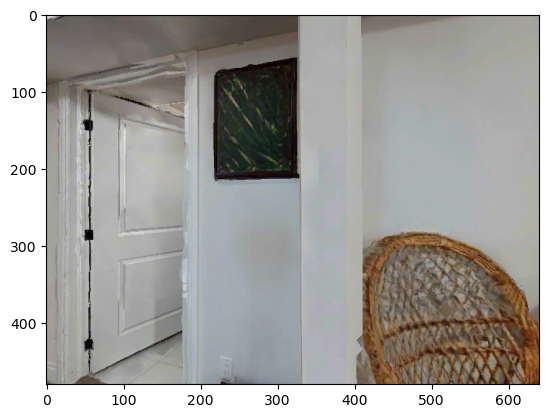

In [11]:
from matplotlib import pyplot as plt

plt.imshow(goal)

In [12]:
def _init_envs(config=None, is_eval: bool = False):
    env_factory: VectorEnvFactory = hydra.utils.instantiate(config.habitat_baselines.vector_env_factory)
    envs = env_factory.construct_envs(
            config,
            workers_ignore_signals=is_slurm_batch_job(),
            enforce_scenes_greater_eq_environments=is_eval,
            is_first_rank=(
                not torch.distributed.is_initialized()
                or torch.distributed.get_rank() == 0
            ),
        )
    _env_spec = EnvironmentSpec(
        observation_space=envs.observation_spaces[0],
        action_space=envs.action_spaces[0],
        orig_action_space=envs.orig_action_spaces[0],
    )

    return envs, _env_spec

In [13]:
envs, env_spec = _init_envs(config)

2023-08-31 11:11:28,002 Initializing dataset PointNav-v1
2023-08-31 11:11:28,003 There are less scenes (1) than environments (2). Each environment will use all the scenes instead of using a subset.
2023-08-31 11:11:33,806 Initializing dataset PointNav-v1
2023-08-31 11:11:34,113 initializing sim Sim-v0
2023-08-31 11:11:35,373 Initializing task Nav-v0
2023-08-31 11:11:37,802 Initializing dataset PointNav-v1
2023-08-31 11:11:38,105 initializing sim Sim-v0
2023-08-31 11:11:39,269 Initializing task Nav-v0


In [14]:
def _create_obs_transforms(config, env_spec):
    obs_transforms = get_active_obs_transforms(config)
    env_spec.observation_space = apply_obs_transforms_obs_space(
            env_spec.observation_space, obs_transforms
        )

In [15]:
_create_obs_transforms(config, env_spec)

2023-08-31 11:11:39,862 Resizing observation of depth: from (480, 640) to (120, 160)
2023-08-31 11:11:39,864 Resizing observation of imagegoal: from (480, 640) to (120, 160)
2023-08-31 11:11:39,865 Resizing observation of rgb: from (480, 640) to (120, 160)


In [16]:
observations = envs.reset()

In [18]:
observations[0].keys()

odict_keys(['depth', 'imagegoal', 'rgb'])